# MNIST Syft Data Scientist

In [1]:
import syft as sy

sy.LOG_FILE = "syft_ds.log"
_ = sy.logger.add(sy.LOG_FILE, enqueue=True, colorize=False, diagnose=True, backtrace=True, level="TRACE")

In [46]:
import torch
from torch import nn

2020-10-31 13:24:14.079 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


# PART 1: Connect to a Remote Duet Server

As the data scientist, you want to perform data science on data that is sitting in the Data Owner's Duet server (in their Notebook).

In order to do this, we must run the code that the Data Owner sends us, which importantly includes their Duet Session ID. This will create a direct connection from my notebook to the remote Duet server. Once the connection is established all traffic is sent directly between the two nodes.

Let's run the code below and follow the instructions it gives.

In [2]:
#duet = sy.join_duet(network_url="http://localhost:5000")
duet = sy.join_duet(network_url="http://localhost:5000", loopback=True)

🎤  🎸  ♪♪♪ joining duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently 
♫♫♫ > in alpha. Do not use this to protect real-world data.
♫♫♫ >
♫♫♫ > Punching through firewall to OpenGrid Network Node at: http://localhost:5000
♫♫♫ > http://localhost:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... id {
  value: "\"\274\326\326i~@\340\236\262\003\010H7\032\265"
}
name: "om-net"
node {
  id {
    value: "\"\274\326\326i~@\340\236\262\003\010H7\032\265"
  }
  name: "om-net"
}

DONE!

♫♫♫ > Duet Client ID: 4c8225d3ee54bc9940d9896becac057b

♫♫♫ > STEP 1: Send the Duet Client ID to your duet partner!

♫♫♫ > ...waiting for partner to connect...
♫♫♫ > ...using a running event loop...


2020-10-31 18:55:58.706 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:56:03.712 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0

♫♫♫ > CONNECTED!


2020-10-31 18:56:08.717 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:56:13.722 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:56:18.728 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


# PART 2: Launch a Duet Server and Connect

In [3]:
import torch as local_torch
from copy import deepcopy
from torch import nn as local_nn


fc1_scaling_factor = 0.25  # this can let us scale the fc1 layer down a bit
def remote_pair(argument):
    def decorator(original_class):        
        def _duet_patch_globals(global_dict):
            global_dict["torch"] = duet.torch
            global_dict["nn"] = duet.torch.nn
        
        def _torch_patch_globals(global_dict):
            global_dict["torch"] = local_torch
            global_dict["nn"] = local_nn
        
        def _restore_globals(global_dict):
            global_dict["torch"] = original_torch
            global_dict["nn"] = original_nn
        
        orig_init = original_class.__init__
        
        def __init__(self, *args, **kws):
            originals = {
                "torch": torch,
                "nn": nn
            }
            global_dict = globals()
            
            _duet_patch_globals(global_dict)
            orig_init(self)
            remote_self = deepcopy(self)
            _torch_patch_globals(global_dict)
            orig_init(self)
            
            _restore_globals(global_dict, originals)

            self.remote = remote_self

        orig_fwd = original_class.forward
        def forward(self, x, remote = False, *args, **kws):
            original_torch = torch
            original_nn = nn
            global_dict = globals()
            
            if remote:
                _duet_patch_globals(global_dict)
                orig_fwd(self.remote_self, *args, **kws)
            else:
                _torch_patch_globals(global_dict)
                orig_fwd(self, *args, **kws)

            restore_globals(global_dict)
            
        original_class.__init__ = __init__
        original_class.forward = forward
        return original_class
    return decorator

@remote_pair(duet)
class SyNet(sy.Module):
    def __init__(self):
        super(SyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, int(64 * fc1_scaling_factor), 3, 1)  # keep fc1 size down
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(int(9216 * fc1_scaling_factor), 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

SyNet()

,ID,Tags,Description
0,<UID:ccf02189-b13a-4cc5-8d3f-eb1bd42e7ec8>,[#age_data],This is a list of people's ages. Let's keep it...


In [4]:
x = duet.syft.lib.python.Int(1)
print(x)

In [5]:
%%time
sy.logger.critical("Start requesting")
if len(duet.store) > 0:
    t = duet.store[0].get(
        request_block=True,
        timeout_secs=15,
        request_name="age_data",
        reason="I want to see the age data",
        delete_obj=False
    )
    sy.logger.critical("Finished requesting")

2020-10-31 18:56:22.840 | CRITICAL | __main__:<module>:1 - Start requesting



> Waiting for Blocking Request
age_data: I want to see the age data.
<UID:b0272382-d190-4444-896f-00fc1a4233bd>

> INSIDE Request BLOCK 0.0 seconds False


2020-10-31 18:56:24.512 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


.
> INSIDE Request BLOCK 1.0618739128112793 seconds False
Joiner PQ: 0 / 0 - CQ: 0 / 0

> Blocking Request ACCEPTED


2020-10-31 18:56:30.153 | CRITICAL | __main__:<module>:10 - Finished requesting


CPU times: user 5.05 s, sys: 382 ms, total: 5.44 s
Wall time: 7.32 s


In [6]:
# print(t)

2020-10-31 18:56:30.160 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


In [7]:
# lets get some references to our data owners Duet torch and torchvision
torch = duet.torch
torchvision = duet.torchvision

# these are the same as the original mnist example
transforms = torchvision.transforms
datasets = torchvision.datasets
nn = torch.nn
F = torch.nn.functional
optim = torch.optim
StepLR = torch.optim.lr_scheduler.StepLR

In [8]:
import torch as th
import torchvision as tv

In [9]:
# we need some transforms for our MNIST data set
local_transform_1 = tv.transforms.ToTensor()  # this converts PIL images to Tensors
local_transform_2 = tv.transforms.Normalize(0.1307, 0.3081)  # this normalizes the dataset

# compose our transforms
local_transforms = tv.transforms.Compose([local_transform_1, local_transform_2])

In [10]:
# Training settings from original MNIST example command line args
args = {
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0,
    "gamma": 0.7,
    "no_cuda": False,
    "dry_run": False,
    "seed": 42, # the meaning of life
    "log_interval": 10,
    "save_model": False,
}

In [11]:
test_kwargs = {
    "batch_size": args["test_batch_size"],
}

# this is our carefully curated test data which represents the goal of our problem domain
test_data = tv.datasets.MNIST('../data', train=False, download=True, transform=local_transforms)
test_loader = th.utils.data.DataLoader(test_data,**test_kwargs)

In [12]:
test_data_length = len(test_loader.dataset)
print(test_data_length)

# test_data_length_ptr = duet.syft.lib.python.Int(test_data_length)
# print(test_data_length_ptr)

10000


In [13]:
print(test_data, type(test_data))

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           ) <class 'torchvision.datasets.mnist.MNIST'>


The "duet" variable is now your reference to a whole world of remote operations including supported libraries like torch.

In [14]:
# # TODO replace with local inference so this doesn't need to be on the DO side
# test_data_ptr = torchvision.datasets.MNIST('../data', train=False, download=True, transform=transforms)
# print(test_data_ptr)

# test_loader_ptr = torch.utils.data.DataLoader(test_data_ptr,**test_kwargs)
# print(test_loader_ptr)
# # TODO

In [15]:
# seq_model = nn.Sequential(
#     nn.Conv2d(1, 32, 3, 1),
#     nn.ReLU(),
#     nn.Conv2d(32, 64, 3, 1),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Dropout2d(0.25),
#     nn.Flatten(),
#     nn.Linear(9216, 128),
#     nn.ReLU(),
#     nn.Dropout2d(0.5),
#     nn.Linear(128, 10),
#     nn.LogSoftmax(dim=1),
# )

In [16]:
# print(t)

Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:32:41.458 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:32:45.423 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:32:46.461 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:32:50.426 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:32:51.466 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:32:55.427 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:32:56.469 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:00.430 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:01.472 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:05.434 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:06.475 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:10.439 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:11.479 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:15.441 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:16.482 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:20.444 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:21.485 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:25.447 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:26.489 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:30.449 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:31.495 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:35.452 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:36.499 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:40.455 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:41.503 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:45.460 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:46.507 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:50.464 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:51.511 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:33:55.467 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:33:56.515 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:00.474 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:01.519 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:05.479 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:06.524 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:10.482 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:11.527 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:15.485 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:16.532 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:20.491 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:21.534 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:25.496 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:26.537 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:30.500 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:31.539 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:35.504 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:36.544 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:40.508 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:41.549 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:45.511 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:46.554 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:50.514 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:51.558 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:34:55.517 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:34:56.564 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:00.521 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:01.569 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:05.525 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:06.572 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:10.528 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:11.576 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:15.534 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:16.581 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:20.540 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:21.584 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:25.547 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:26.588 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:30.553 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:31.596 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:35.557 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:36.600 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:40.562 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:41.603 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:45.567 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:46.606 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:50.569 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:51.609 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:35:55.577 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:35:56.612 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:00.583 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:01.615 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:05.587 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:06.617 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:10.591 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:11.622 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:15.595 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:16.627 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:20.596 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:21.630 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:25.602 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:26.634 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:30.606 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:31.638 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:35.610 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:36.642 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:40.618 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:41.646 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:45.621 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:46.652 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:50.625 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:51.656 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:36:55.632 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:36:56.660 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:00.635 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:01.666 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:05.639 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:06.668 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:10.645 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:11.673 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:15.650 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:16.676 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:20.656 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:21.679 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:25.660 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:26.685 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:30.665 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:31.689 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:35.669 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:36.694 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:40.674 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:41.697 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:45.680 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:46.703 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:50.685 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:51.708 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:37:55.688 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:37:56.713 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:00.695 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:01.717 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:05.700 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:06.724 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:10.703 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:11.727 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:15.707 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:16.732 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:20.710 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:21.734 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:25.713 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:26.740 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:30.718 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:31.743 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:35.721 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:36.748 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:40.724 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:41.750 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:45.728 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:46.755 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:50.735 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:51.757 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:38:55.738 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:38:56.762 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:00.741 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:01.764 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:05.744 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:06.767 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:10.749 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:11.770 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:15.752 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:16.773 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:20.758 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:21.777 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:25.760 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:26.779 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:30.762 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:31.783 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:35.768 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:36.788 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:40.772 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:41.792 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:45.777 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:46.796 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:50.779 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:51.798 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:39:55.782 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:39:56.800 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:00.784 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:01.803 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:05.788 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:06.806 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:10.790 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:11.808 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:15.793 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:16.811 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:20.796 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:21.814 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:25.804 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:26.817 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:30.811 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:31.820 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:35.815 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:36.824 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:40.820 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:41.832 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:45.827 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:46.836 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:50.831 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:51.839 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:40:55.836 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:40:56.843 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:00.839 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:01.847 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:05.843 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:06.852 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:10.846 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:11.854 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:15.847 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:16.857 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:20.850 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:21.860 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:25.855 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:26.869 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:30.856 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:31.871 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:35.860 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:36.879 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:40.864 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:41.883 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:45.866 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:46.887 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:50.870 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:51.892 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:41:55.880 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:41:56.897 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:00.885 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:01.899 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:05.891 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:06.905 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:10.900 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:11.910 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:15.905 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:16.915 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:20.908 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:21.919 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:25.912 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:26.923 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:30.916 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:31.926 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:35.919 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:36.928 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:40.923 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:41.932 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:45.927 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:46.939 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:50.931 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:51.944 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:42:55.933 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:42:56.947 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:00.936 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:01.952 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:05.939 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:06.958 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:10.941 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:11.961 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:15.945 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:16.964 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:20.947 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:21.970 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:25.950 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:26.975 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:30.956 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:31.978 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:35.958 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:36.980 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:40.960 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:41.983 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:45.965 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:46.986 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:50.967 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:51.990 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:43:55.969 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:43:56.995 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:00.972 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:02.005 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:05.977 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:07.008 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:10.983 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:12.019 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:15.988 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:17.022 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:20.995 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:22.026 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:25.999 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:27.031 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:31.002 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:32.035 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:36.007 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:37.039 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:41.011 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:42.044 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:46.015 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:47.048 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:51.018 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:52.051 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:44:56.020 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:44:57.055 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:01.021 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:02.060 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:06.025 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:07.064 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:11.026 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:12.066 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:16.030 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:17.070 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:21.034 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:22.074 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:26.036 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:27.080 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:31.041 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:32.087 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:36.044 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:37.092 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:41.048 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:42.101 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:46.053 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:47.106 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:51.058 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:52.114 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:45:56.062 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:45:57.118 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:01.066 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:02.121 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:06.074 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:07.125 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:11.078 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:12.135 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:16.084 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:17.139 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:21.087 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:22.142 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:26.091 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:27.146 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:31.096 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:32.152 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:36.100 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:37.156 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:41.107 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:42.158 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:46.115 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:47.162 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:51.122 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:52.165 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:46:56.128 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:46:57.170 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:01.133 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:02.173 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:06.139 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:07.175 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:11.145 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:12.178 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:16.149 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:17.180 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:21.152 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:22.184 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:26.156 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:27.187 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:31.163 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:32.191 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:36.168 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:37.193 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:41.172 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:42.197 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:46.176 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:47.199 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:51.178 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:52.208 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:47:56.184 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:47:57.211 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:01.188 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:02.213 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:06.193 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:07.217 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:11.197 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:12.219 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:16.200 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:17.224 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:21.202 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:22.226 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:26.207 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:27.231 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:31.211 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:32.234 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:36.216 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:37.238 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:41.218 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:42.242 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:46.224 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:47.248 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:51.230 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:52.252 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:48:56.238 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:48:57.259 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:01.244 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:02.262 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:06.248 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:07.265 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:11.253 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:12.269 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:16.257 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:17.272 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:21.258 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:22.274 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:26.262 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:27.277 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:31.266 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:32.281 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:36.272 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:37.284 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:41.277 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:42.288 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:46.279 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:47.292 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:51.282 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:52.295 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:49:56.284 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:49:57.297 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:01.288 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:02.305 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:06.296 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:07.310 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:11.299 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:12.314 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:16.303 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:17.318 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:21.308 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:22.323 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:26.313 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:27.329 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:31.316 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:32.332 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:36.322 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:37.337 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:41.326 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:42.342 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:46.331 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:47.346 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:51.338 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:52.350 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:50:56.342 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:50:57.352 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:01.349 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:02.356 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:06.352 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:07.360 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:11.357 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:12.362 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:16.361 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:17.369 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:21.366 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:22.372 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:26.370 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:27.376 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:31.374 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:32.378 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:36.383 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:37.387 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:41.387 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:42.391 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:46.395 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:47.395 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:51.402 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:52.402 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:51:56.408 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:51:57.408 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:01.414 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:02.416 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:06.418 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:07.419 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:11.421 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:12.423 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:16.426 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:17.428 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:21.431 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:22.436 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:26.436 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:27.440 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:31.439 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:32.447 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:36.444 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:37.452 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:41.448 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:42.457 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:46.451 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:47.461 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:51.456 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:52.464 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:52:56.461 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:52:57.470 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:01.465 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:02.474 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:06.470 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:07.479 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:11.476 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:12.482 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:16.480 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:17.489 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:21.488 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:22.494 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:26.491 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:27.497 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:31.493 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:32.499 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:36.496 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:37.502 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:41.504 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:42.503 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:46.509 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:47.505 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:51.512 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:52.509 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:53:56.514 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:53:57.511 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:01.518 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:02.514 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:06.521 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:07.520 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:11.525 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:12.524 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:16.528 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:17.529 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:21.530 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:22.533 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:26.534 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:27.535 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:31.538 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:32.539 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:36.542 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:37.544 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:41.545 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:42.546 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:46.550 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:47.550 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:51.556 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:52.553 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:54:56.563 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:54:57.558 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:01.568 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:02.562 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:06.571 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:07.564 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:11.578 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:12.570 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:16.582 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:17.575 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:21.586 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:22.579 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:26.592 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:27.586 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:31.596 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:32.590 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:36.601 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:37.598 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:41.604 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:42.600 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:46.614 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:47.604 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:51.620 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:52.607 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:55:56.625 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:55:57.613 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:01.629 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:02.617 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:06.631 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:07.621 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:11.633 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:12.625 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:16.635 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:17.635 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:21.640 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:22.638 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:26.645 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:27.642 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:31.657 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:32.647 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:36.663 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:37.651 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:41.666 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:42.656 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:46.670 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:47.658 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:51.674 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:52.668 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:56:56.684 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:56:57.676 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:57:01.689 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:57:02.679 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:57:06.693 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:57:07.686 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:57:11.699 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:57:12.695 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:57:16.705 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:57:17.703 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:57:21.708 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:57:22.709 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:57:26.713 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


In [76]:
# lets get some references to our data owners Duet torch and torchvision
torch = duet.torch
torchvision = duet.torchvision

# these are the same as the original mnist example
transforms = torchvision.transforms
datasets = torchvision.datasets
nn = torch.nn
F = torch.nn.functional
optim = torch.optim
StepLR = torch.optim.lr_scheduler.StepLR

In [77]:
import torch as th
import torchvision as tv

In [78]:
# we need some transforms for our MNIST data set
local_transform_1 = tv.transforms.ToTensor()  # this converts PIL images to Tensors
local_transform_2 = tv.transforms.Normalize(0.1307, 0.3081)  # this normalizes the dataset

# compose our transforms
local_transforms = tv.transforms.Compose([local_transform_1, local_transform_2])

In [79]:
# Training settings from original MNIST example command line args
args = {
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0,
    "gamma": 0.7,
    "no_cuda": False,
    "dry_run": False,
    "seed": 42, # the meaning of life
    "log_interval": 10,
    "save_model": False,
}

In [80]:
test_kwargs = {
    "batch_size": args["test_batch_size"],
}

# this is our carefully curated test data which represents the goal of our problem domain
test_data = tv.datasets.MNIST('../data', train=False, download=True, transform=local_transforms)
test_loader = th.utils.data.DataLoader(test_data,**test_kwargs)

2020-10-31 13:31:40.310 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


In [81]:
test_data_length = len(test_loader.dataset)
print(test_data_length)

# test_data_length_ptr = duet.syft.lib.python.Int(test_data_length)
# print(test_data_length_ptr)

Joiner PQ: 0 / 29 - CQ: 0 / 0
10000


In [82]:
print(test_data, type(test_data))

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           ) <class 'torchvision.datasets.mnist.MNIST'>


2020-10-31 13:31:41.416 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


The "duet" variable is now your reference to a whole world of remote operations including supported libraries like torch.

In [83]:
# # TODO replace with local inference so this doesn't need to be on the DO side
# test_data_ptr = torchvision.datasets.MNIST('../data', train=False, download=True, transform=transforms)
# print(test_data_ptr)

# test_loader_ptr = torch.utils.data.DataLoader(test_data_ptr,**test_kwargs)
# print(test_loader_ptr)
# # TODO

In [84]:
# seq_model = nn.Sequential(
#     nn.Conv2d(1, 32, 3, 1),
#     nn.ReLU(),
#     nn.Conv2d(32, 64, 3, 1),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Dropout2d(0.25),
#     nn.Flatten(),
#     nn.Linear(9216, 128),
#     nn.ReLU(),
#     nn.Dropout2d(0.5),
#     nn.Linear(128, 10),
#     nn.LogSoftmax(dim=1),
# )

In [85]:
# class Net:
#     modules = []
#     training = False

#     def __init__(self) -> None:
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(9216, 128)
#         self.fc2 = nn.Linear(128, 10)

#         # add to modules list
#         self.modules.append(self.conv1)
#         self.modules.append(self.conv2)
#         self.modules.append(self.dropout1)
#         self.modules.append(self.dropout2)
#         self.modules.append(self.fc1)
#         self.modules.append(self.fc2)

#     def train(self, mode: bool = True):
#         self.training = mode
#         for module in self.modules:
#             module.train(mode)
#         return self

#     def eval(self):
#         return self.train(False)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output

#     def __call__(self, input):
#         return self.forward(input)

#     # local list of remote ListPointers of TensorPointers
#     def parameters(self, recurse: bool = True):
#         params_list = duet.syft.lib.python.List()
#         for module in self.modules:
#             param_pointers = module.parameters()
#             params_list += param_pointers

#         return params_list

#     def cuda(self, device) -> "Net":
#         for module in self.modules:
#             module.cuda(device)
#         return self

#     def cpu(self) -> "Net":
#         for module in self.modules:
#             module.cpu()
#         return self

In [17]:
# # lets define our SOTA model to train on the data owners data
# # note we subclass from sy.Module not nn.Module
# fc1_scaling_factor = 0.25  # this can let us scale the fc1 layer down a bit
# def remote_pair(argument):
#     def decorator(original_class):
#         orig_init = original_class.__init__

#         def __init__(self, *args, **kws):
#             orig_init(self, *args, **kws)

#         original_class.__init__ = __init__
#         return original_class
#     return decorator

# @remote_pair(duet)
# class SyNet(sy.Module):
#     def __init__(self):
#         super(SyNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, int(64 * fc1_scaling_factor), 3, 1)  # keep fc1 size down
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(int(9216 * fc1_scaling_factor), 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output

# SyNet()

In [18]:
# # lets define our SOTA model to train on the data owners data
# # note we subclass from sy.Module not nn.Module
# # WARNING: be extra careful to use th. not the torch from duet here
# class LocalSyNet(sy.Module):
#     def __init__(self):
#         super(LocalSyNet, self).__init__()
#         self.conv1 = th.nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = th.nn.Conv2d(32, int(64 * fc1_scaling_factor), 3, 1)
#         self.dropout1 = th.nn.Dropout2d(0.25)
#         self.dropout2 = th.nn.Dropout2d(0.5)
#         self.fc1 = th.nn.Linear(int(9216 * fc1_scaling_factor), 128)
#         self.fc2 = th.nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = th.nn.functional.relu(x)
#         x = self.conv2(x)
#         x = th.nn.functional.relu(x)
#         x = th.nn.functional.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = th.flatten(x, 1)
#         x = self.fc1(x)
#         x = th.nn.functional.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = th.nn.functional.log_softmax(x, dim=1)
#         return output

In [19]:
# class SmallSyNet(sy.Module):
#     def __init__(self):
#         super(SmallSyNet, self).__init__()
#         self.fc1 = nn.Linear(784, 392)
#         self.fc2 = nn.Linear(392, 10)

#     def forward(self, x):
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         return x

2020-10-31 13:31:45.312 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:31:46.420 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


In [20]:
# class LocalSmallSyNet(sy.Module):
#     def __init__(self):
#         super(LocalSmallSyNet, self).__init__()
#         self.fc1 = th.nn.Linear(784, 392)
#         self.fc2 = th.nn.Linear(392, 10)

#     def forward(self, x):
#         x = th.flatten(x, 1)
#         x = self.fc1(x)
#         x = th.nn.functional.relu(x)
#         x = self.fc2(x)
#         return x    

In [21]:
# lets see if our Data Owner has CUDA
has_cuda = False
has_cuda_ptr = torch.cuda.is_available()
has_cuda = bool(has_cuda_ptr.get(
    request_block=True,
    request_name="cuda_is_available",
    reason="To run test and inference locally",
    timeout_secs=30,  # change to something slower
))
print(has_cuda)

2020-10-31 18:56:35.616 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0



> Waiting for Blocking Request
cuda_is_available: To run test and inference locally.
<UID:d6849e4e-db1f-4b95-91eb-245d555af0bb>

> INSIDE Request BLOCK 0.0 seconds False
Joiner PQ: 0 / 0 - CQ: 0 / 0
.
> INSIDE Request BLOCK 1.0878069400787354 seconds False

> Blocking Request ACCEPTED
False


In [22]:
use_cuda = not args["no_cuda"] and has_cuda
torch.manual_seed(args["seed"])

device = torch.device("cuda" if use_cuda else "cpu")
print(f"DO device is {device.type.get()}")

DO device is cpu


In [23]:
# instantiate our model
# this will construct everything inside init on the DO side
# model = Net()
model = SyNet()
# model = seq_model
# model = SmallSyNet()

TypeError: deepcopy() missing 1 required positional argument: 'x'

In [24]:
print(len(model.modules))
print(model.modules)

6
OrderedDict([('conv1', <syft.proxy.torch.nn.Conv2dPointer object at 0x140a85640>), ('conv2', <syft.proxy.torch.nn.Conv2dPointer object at 0x140999850>), ('dropout1', <syft.proxy.torch.nn.Dropout2dPointer object at 0x110e5cbe0>), ('dropout2', <syft.proxy.torch.nn.Dropout2dPointer object at 0x140a85af0>), ('fc1', <syft.proxy.torch.nn.LinearPointer object at 0x140a850d0>), ('fc2', <syft.proxy.torch.nn.LinearPointer object at 0x1409aeee0>)])


In [25]:
# local_model = LocalSyNet()
# local_model = LocalSmallSyNet()
# local_model.zero_layers()  # so we can confirm that the weight download works
# local_model.sum_layers()
# print(local_model.modules)
# assert local_model.fc1.in_features == int(9216 * fc1_scaling_factor)

> Layer conv1 sum(weight): 0.0
> Layer conv1 sum(bias): 0.0
> Layer conv2 sum(weight): 0.0
> Layer conv2 sum(bias): 0.0
> Layer fc1 sum(weight): 0.0
> Layer fc1 sum(bias): 0.0
> Layer fc2 sum(weight): 0.0
> Layer fc2 sum(bias): 0.0
OrderedDict([('conv1', Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))), ('conv2', Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))), ('dropout1', Dropout2d(p=0.25, inplace=False)), ('dropout2', Dropout2d(p=0.5, inplace=False)), ('fc1', Linear(in_features=2304, out_features=128, bias=True)), ('fc2', Linear(in_features=128, out_features=10, bias=True))])


In [26]:
# local_model.copy_remote_state(
#     remote_model=model,
#     request_name="model_download",
#     reason="test evaluation",
#     timeout_secs=30
# )

> Downloading remote: conv1

> Waiting for Blocking Request
model_download: test evaluation.
<UID:e995a1e9-b5cc-41e9-88e2-0e8179aec517>

> INSIDE Request BLOCK 0.0 seconds False


2020-10-31 18:56:40.793 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


.
> INSIDE Request BLOCK 1.0753378868103027 seconds False
Joiner PQ: 0 / 0 - CQ: 0 / 0

> Blocking Request ACCEPTED
>> Setting weight copy on local conv1
>> Setting bias copy on local conv1
> Finished downloading model
> Downloading remote: conv2

> Waiting for Blocking Request
model_download: test evaluation.
<UID:17637330-b817-4103-ad15-af91335ae683>

> INSIDE Request BLOCK 9.5367431640625e-07 seconds False
.
> INSIDE Request BLOCK 1.073065996170044 seconds False

> Blocking Request ACCEPTED
>> Setting weight copy on local conv2
>> Setting bias copy on local conv2
> Finished downloading model
> Finished downloading model
> Finished downloading model
> Downloading remote: fc1

> Waiting for Blocking Request
model_download: test evaluation.
<UID:80b6edfa-645b-49dc-85de-0944b60cac5c>

> INSIDE Request BLOCK 0.0 seconds False
.
> INSIDE Request BLOCK 1.0792078971862793 seconds False

> Blocking Request ACCEPTED
>> Setting weight copy on local fc1
>> Setting bias copy on local fc1
> Finis

2020-10-31 18:56:45.799 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0



> Waiting for Blocking Request
model_download: test evaluation.
<UID:06e2ab14-6a5f-440a-8800-ee418681d5a2>

> INSIDE Request BLOCK 0.0 seconds False
Joiner PQ: 0 / 0 - CQ: 0 / 0
.
> INSIDE Request BLOCK 1.1488988399505615 seconds False

> Blocking Request ACCEPTED
>> Setting weight copy on local fc2
>> Setting bias copy on local fc2
> Finished downloading model


In [27]:
# print("done")
# local_model.sum_layers()
# # %%time
# # skip_layers = []
# # # warning fc1 is 9216x128 and stalls on copy, even a tensor size 9216x96 takes 45 seconds
# # # skip_layers.append("fc1") # fc1 is too big???
# # # warning fc1 at 4608x128 takes about 25 seconds
# # local_model.copy_remote_state(remote_model=model, skip_layers=skip_layers)

done
> Layer conv1 sum(weight): -4.843146324157715
> Layer conv1 sum(bias): -0.2682029604911804
> Layer conv2 sum(weight): -1.074238896369934
> Layer conv2 sum(bias): -0.029183562844991684
> Layer fc1 sum(weight): 1.8069207668304443
> Layer fc1 sum(bias): -0.15532046556472778
> Layer fc2 sum(weight): -4.656699180603027
> Layer fc2 sum(bias): -0.148866668343544


In [28]:
# # check the weights were copied
# local_model.sum_layers()

In [29]:
# if we have CUDA lets send our model to the GPU
if has_cuda:
    model.cuda(device)
else:
    model.cpu()

2020-10-31 13:26:05.052 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:06.179 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:10.056 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:11.181 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:15.059 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:16.183 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:20.061 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:21.187 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:25.065 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:26.190 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:30.076 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:31.194 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:35.080 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:36.197 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:40.083 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:41.200 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:45.091 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:46.202 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:50.098 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:51.209 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:26:55.100 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:26:56.212 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:00.101 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:01.216 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:05.105 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:06.223 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:10.114 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:11.228 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:15.116 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:16.231 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:20.119 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:21.233 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:25.122 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:26.235 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:30.128 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:31.237 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:35.132 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:36.240 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:40.134 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:41.243 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:45.139 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:46.245 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:50.144 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:51.250 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:27:55.146 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:27:56.254 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:00.151 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:01.257 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:05.157 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:06.260 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:10.161 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:11.264 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:15.166 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:16.267 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:20.169 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:21.270 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:25.173 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:26.274 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:30.180 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:31.282 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:35.184 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:36.285 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:40.188 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:41.288 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:45.191 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:46.292 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:50.194 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:51.295 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:28:55.199 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:28:56.299 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:00.201 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:01.302 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:05.204 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:06.306 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:10.207 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:11.308 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:15.209 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:16.310 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:20.213 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:21.316 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:25.218 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:26.320 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:30.221 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:31.322 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:35.227 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:36.324 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:40.229 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:41.328 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 13:29:45.234 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 29 - CQ: 0 / 0


Joiner PQ: 0 / 29 - CQ: 0 / 0


2020-10-31 13:29:46.332 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


In [30]:
# lets get our parameters for optimization
# params_list required for remote list concatenation
params = model.remote_self.parameters(params_list=duet.syft.lib.python.List())
print(params, type(params))

<syft.proxy.syft.lib.python.ListPointer object at 0x140a944c0> <class 'syft.proxy.syft.lib.python.ListPointer'>


In [31]:
optimizer = optim.Adadelta(params, lr=args["lr"])
print(optimizer, type(optimizer))

<syft.proxy.torch.optim.AdadeltaPointer object at 0x140b55760> <class 'syft.proxy.torch.optim.AdadeltaPointer'>


In [32]:
scheduler = StepLR(optimizer, step_size=1, gamma=args["gamma"])
print(scheduler, type(scheduler))

<syft.proxy.torch.optim.lr_scheduler.StepLRPointer object at 0x140b39820> <class 'syft.proxy.torch.optim.lr_scheduler.StepLRPointer'>


In [33]:
# now can define a simple training loop very similar to the original PyTorch MNIST example
@sy.logger.catch
def train(args, model, device, train_loader, optimizer, epoch, train_data_length):
    # + 0.5 lets us math.ceil without the import
    train_batches = round((train_data_length / args["batch_size"]) + 0.5)
#     train_batches = 100
    print(f"> Running train in {train_batches} batches")
    model.train()

    for batch_idx, data in enumerate(train_loader):
#         time.sleep(1)
        data_ptr, target_ptr = data[0], data[1]
        optimizer.zero_grad()
        output = model(data_ptr)
        loss = F.nll_loss(output, target_ptr)
        loss.backward()
        optimizer.step()
        loss_item = loss.item()
        train_loss = duet.syft.lib.python.Float(0)
        train_loss += loss_item
        if batch_idx % args["log_interval"] == 0:
#             local_loss = loss_item.get(
#                 request_name="loss",
#                 reason="To evaluate training progress",
#                 request_block=True,
#                 timeout_secs=30
#             )
            local_loss = None
            if local_loss is not None:
                print("Train Epoch: {} {} {:.4}".format(epoch, batch_idx, local_loss))
            else:
                print("Train Epoch: {} {} ?".format(epoch, batch_idx))
            if args["dry_run"]:
                break
        if batch_idx >= train_batches - 1:
            print("batch_idx >= train_batches, breaking")
            break

2020-10-31 18:56:50.804 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


In [34]:
# # TODO replace with local inference and local test set
# # the same for our test training loop except we will need to send our data over for inference
# def test(model, device, test_loader, test_data_length):
#     # + 0.5 lets us math.ceil without the import
#     test_batches = round((test_data_length / args["test_batch_size"]) + 0.5)
#     print(f"> Running test in {test_batches} batches")
#     model.eval()
#     test_loss = duet.syft.lib.python.Float(0)
#     correct_ptr = duet.syft.lib.python.Float(0)

#     with torch.no_grad():
#         for batch_idx, data in enumerate(test_loader):
#             data_ptr, target_ptr = data[0], data[1]
#             output = model(data_ptr)
#             loss = F.nll_loss(output, target_ptr, reduction='sum').item()
#             test_loss = test_loss + loss

#             pred = output.argmax(dim=1)
#             total = pred.eq(target_ptr).sum().item()
#             correct_ptr += total

#             if args["dry_run"]:
#                 break
                
#             if batch_idx >= test_batches - 1:
#                 print("batch_idx >= test_batches, breaking")
#                 break

#     accuracy = correct_ptr / test_data_length
#     # we need to batch or block these requests so the loop doesnt break
#     result = None
# #     result = accuracy.get(
# #         request_block=True,
# #         timeout_secs=0,
# #         request_name="accuracy",
# #         reason="To see the accuracy on DO's test set"
# #     )
#     if result is not None:
#         print("Test Set Average Loss:", 100 * result)
#     else:
#         print("Test Set Average Loss: ?")

2020-10-31 18:56:55.810 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:00.816 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:05.821 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:10.827 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:15.832 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:20.838 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:25.841 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:30.843 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:35.845 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:40.851 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:45.856 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:50.862 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:57:55.867 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:58:00.872 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


In [35]:
# TODO replace with local inference and local test set
# the same for our test training loop except we will need to send our data over for inference
@sy.logger.catch
def test_local(model, remote_model, test_loader, test_data_length):
    # download remote model
    model.copy_remote_state(
        remote_model=remote_model,
        request_name="model_download",
        reason="test evaluation",
        timeout_secs=30
    )
    # visually check the weights have changed
    model.sum_layers()
    # + 0.5 lets us math.ceil without the import
    test_batches = round((test_data_length / args["test_batch_size"]) + 0.5)
    print(f"> Running test_local in {test_batches} batches")
    model.eval()
    test_loss = 0.0
    correct = 0.0

    with th.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
#             time.sleep(1)
            output = model(data)
            iter_loss = th.nn.functional.nll_loss(output, target, reduction='sum').item()
            test_loss = test_loss + iter_loss
            pred = output.argmax(dim=1)
            total = pred.eq(target).sum().item()
            correct += total
            if args["dry_run"]:
                break
                
            if batch_idx >= test_batches - 1:
                print("batch_idx >= test_batches, breaking")
                break

    accuracy = correct / test_data_length
    print("Test Set Average Loss:", 100 * accuracy)

In [36]:
# we need some transforms for our MNIST data set
transform_1 = torchvision.transforms.ToTensor()  # this converts PIL images to Tensors
transform_2 = torchvision.transforms.Normalize(0.1307, 0.3081)  # this normalizes the dataset
print(type(transform_1), type(transform_2))

remote_list = duet.syft.lib.python.List()
remote_list.append(transform_1)
remote_list.append(transform_2)

# compose our transforms
transforms = torchvision.transforms.Compose(remote_list)

# The DO has kindly let us initialise a DataLoader for their training set
train_kwargs = {
    "batch_size": args["batch_size"],
}
train_data_ptr = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transforms)
print(train_data_ptr)
train_loader_ptr = torch.utils.data.DataLoader(train_data_ptr,**train_kwargs)
print(train_loader_ptr)

<class 'syft.proxy.torchvision.transforms.ToTensorPointer'> <class 'syft.proxy.torchvision.transforms.NormalizePointer'>


In [37]:
def get_train_length(train_data_ptr):
    train_length_ptr = train_data_ptr.__len__()
    train_data_length = train_length_ptr.get(
        request_block=True,
        request_name="train_size",
        reason="To write the training loop",
        timeout_secs=30,
    )
    return train_data_length

try:
    if train_data_length is None:
        train_data_length = get_train_length(train_data_ptr)
except NameError:
        train_data_length = get_train_length(train_data_ptr)

print(f"Training Dataset size is: {train_data_length}")


> Waiting for Blocking Request
train_size: To write the training loop.
<UID:3b8c8933-d8cc-48d9-97d6-f5162490f00e>

> INSIDE Request BLOCK 0.0 seconds False


2020-10-31 18:58:06.122 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


.
> INSIDE Request BLOCK 1.0774312019348145 seconds False
Joiner PQ: 0 / 0 - CQ: 0 / 0

> Blocking Request ACCEPTED
Training Dataset size is: 60000


2020-10-31 18:58:11.125 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 18:58:16.127 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


In [38]:
%%time
import time
# sequential CPU times: user 39.2 s, sys: 390 ms, total: 39.6s per epoch
# sy.module CPU times: user 1min 28s, sys: 645 ms, total: 1min 28s per epoch
# vanilla class CPU times: user 3min 5s, sys: 3.01 s, total: 3min 8s per epoch

args["dry_run"] = False
sy.logger.trace("Start Training")
for epoch in range(1, args["epochs"] + 1):
    epoch_start = time.time()
    print(f"Epoch: {epoch}")
    train(args, model, device, train_loader_ptr, optimizer, epoch, train_data_length)
    #test(model, device, test_loader_ptr, test_data_length_ptr)
    test_local(local_model, model, test_loader, test_data_length)  # real local data and model
    scheduler.step()
    epoch_end = time.time()
    print(f"Epoch time: {int(epoch_end - epoch_start)} seconds")
    break
sy.logger.trace("Finish Training")

Epoch: 1
> Running train in 938 batches
Train Epoch: 1 0 ?


2020-10-31 18:58:21.139 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 10 ?


2020-10-31 18:58:26.152 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 20 ?


2020-10-31 18:58:31.163 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 30 ?


2020-10-31 18:58:36.174 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 40 ?


2020-10-31 18:58:41.188 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 50 ?


2020-10-31 18:58:46.206 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 60 ?


2020-10-31 18:58:51.223 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 70 ?


2020-10-31 18:58:56.233 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 80 ?


2020-10-31 18:59:01.248 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 90 ?


2020-10-31 18:59:06.262 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 100 ?


2020-10-31 18:59:11.278 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 110 ?


2020-10-31 18:59:16.301 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 120 ?


2020-10-31 18:59:21.313 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 130 ?


2020-10-31 18:59:26.327 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 140 ?


2020-10-31 18:59:31.344 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 150 ?


2020-10-31 18:59:36.360 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 160 ?


2020-10-31 18:59:41.376 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 170 ?
Train Epoch: 1 180 ?


2020-10-31 18:59:46.388 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 190 ?


2020-10-31 18:59:51.403 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 200 ?


2020-10-31 18:59:56.417 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 210 ?


2020-10-31 19:00:01.432 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 220 ?


2020-10-31 19:00:06.443 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 230 ?


2020-10-31 19:00:11.459 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 240 ?


2020-10-31 19:00:16.475 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 250 ?


2020-10-31 19:00:21.491 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 260 ?


2020-10-31 19:00:26.504 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 270 ?


2020-10-31 19:00:31.520 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 280 ?


2020-10-31 19:00:36.540 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 290 ?


2020-10-31 19:00:41.555 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 300 ?


2020-10-31 19:00:46.570 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 310 ?


2020-10-31 19:00:51.582 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 320 ?


2020-10-31 19:00:56.596 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 330 ?


2020-10-31 19:01:01.623 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 340 ?


2020-10-31 19:01:06.634 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 350 ?


2020-10-31 19:01:11.649 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:01:16.663 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Train Epoch: 1 360 ?
Train Epoch: 1 370 ?
Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 380 ?


2020-10-31 19:01:21.682 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 390 ?


2020-10-31 19:01:26.695 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 400 ?


2020-10-31 19:01:31.707 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 410 ?


2020-10-31 19:01:36.729 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 420 ?


2020-10-31 19:01:41.746 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 430 ?


2020-10-31 19:01:46.757 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 440 ?


2020-10-31 19:01:51.770 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 450 ?


2020-10-31 19:01:56.782 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 460 ?


2020-10-31 19:02:01.800 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 470 ?


2020-10-31 19:02:06.813 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 480 ?


2020-10-31 19:02:11.836 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 490 ?


2020-10-31 19:02:16.852 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 500 ?


2020-10-31 19:02:21.863 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 510 ?


2020-10-31 19:02:26.880 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 520 ?


2020-10-31 19:02:31.890 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 530 ?


2020-10-31 19:02:36.901 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 540 ?


2020-10-31 19:02:41.920 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Train Epoch: 1 550 ?
Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 560 ?


2020-10-31 19:02:46.939 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 570 ?


2020-10-31 19:02:51.958 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 580 ?


2020-10-31 19:02:56.975 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 590 ?


2020-10-31 19:03:01.991 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 600 ?


2020-10-31 19:03:07.005 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 610 ?


2020-10-31 19:03:12.018 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 620 ?


2020-10-31 19:03:17.038 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 630 ?


2020-10-31 19:03:22.051 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 640 ?


2020-10-31 19:03:27.069 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 650 ?


2020-10-31 19:03:32.078 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 660 ?
Train Epoch: 1 670 ?


2020-10-31 19:03:37.097 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 680 ?


2020-10-31 19:03:42.112 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 690 ?


2020-10-31 19:03:47.131 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 700 ?


2020-10-31 19:03:52.154 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 710 ?


2020-10-31 19:03:57.171 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 720 ?


2020-10-31 19:04:02.181 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 730 ?


2020-10-31 19:04:07.192 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 740 ?


2020-10-31 19:04:12.205 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 750 ?


2020-10-31 19:04:17.219 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 760 ?


2020-10-31 19:04:22.237 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Train Epoch: 1 770 ?
Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 780 ?


2020-10-31 19:04:27.259 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 790 ?


2020-10-31 19:04:32.271 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 800 ?


2020-10-31 19:04:37.284 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 810 ?


2020-10-31 19:04:42.295 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 820 ?


2020-10-31 19:04:47.312 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 830 ?


2020-10-31 19:04:52.326 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 840 ?


2020-10-31 19:04:57.342 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Train Epoch: 1 850 ?
Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 860 ?


2020-10-31 19:05:02.359 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 870 ?


2020-10-31 19:05:07.374 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 880 ?


2020-10-31 19:05:12.394 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 890 ?


2020-10-31 19:05:17.405 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 900 ?


2020-10-31 19:05:22.418 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 910 ?


2020-10-31 19:05:27.436 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 920 ?


2020-10-31 19:05:32.450 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0
Train Epoch: 1 930 ?
batch_idx >= train_batches, breaking
> Downloading remote: conv1

> Waiting for Blocking Request
model_download: test evaluation.
<UID:cbca578a-25d8-4b45-a477-990a002e75c8>

> INSIDE Request BLOCK 0.0 seconds False


2020-10-31 19:05:37.452 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:05:42.456 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:05:47.457 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:05:52.460 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:05:57.463 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:02.464 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:07.466 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:12.467 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:17.471 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:22.472 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:27.475 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:32.476 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:37.479 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:42.480 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:47.482 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:52.485 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:06:57.487 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:02.488 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:07.489 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:12.491 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:17.492 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:22.493 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:27.496 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:32.497 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:37.500 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:42.502 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:47.504 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:52.506 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:07:57.509 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:02.513 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:07.513 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:12.514 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:17.516 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:22.518 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:27.520 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:32.521 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:37.525 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:42.526 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:47.528 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:52.531 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:08:57.533 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:02.534 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:07.535 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:12.536 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:17.540 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:22.542 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:27.547 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:32.549 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:37.551 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:42.552 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:47.553 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:52.555 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:09:57.558 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:02.561 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:07.564 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:12.565 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:17.567 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:22.570 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:27.572 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:32.572 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:37.575 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:42.577 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:47.579 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:52.581 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:10:57.585 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:02.587 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:07.589 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:12.591 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:17.593 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:22.594 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:27.598 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:32.599 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:37.600 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:42.602 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:47.603 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:52.606 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:11:57.609 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:12:02.611 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:12:07.613 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:12:12.614 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:12:17.616 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:12:22.618 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:12:27.622 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:12:32.250 | ERROR    | syft.core.common.module:copy_remote_state:163 - Failed to download remote state for conv1. 'NoneType' object has no attribute 'items'


.
> INSIDE Request BLOCK 415.3126759529114 seconds True

> Blocking Request Timeout after 30 seconds
> Downloading remote: conv2


2020-10-31 19:12:32.792 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0



> Waiting for Blocking Request
model_download: test evaluation.
<UID:a1bcafd5-fded-4a1a-92eb-d2b8d42c3709>

> INSIDE Request BLOCK 9.5367431640625e-07 seconds False
Joiner PQ: 0 / 0 - CQ: 0 / 0
.
> INSIDE Request BLOCK 1.0744011402130127 seconds False

> Blocking Request ACCEPTED
>> Setting weight copy on local conv2
>> Setting bias copy on local conv2
> Finished downloading model
> Finished downloading model
> Finished downloading model
> Downloading remote: fc1

> Waiting for Blocking Request
model_download: test evaluation.
<UID:2188586c-7ade-409c-b6b9-384be459a778>

> INSIDE Request BLOCK 0.0 seconds False
.
> INSIDE Request BLOCK 1.0709500312805176 seconds False

> Blocking Request ACCEPTED
>> Setting weight copy on local fc1
>> Setting bias copy on local fc1
> Finished downloading model
> Downloading remote: fc2

> Waiting for Blocking Request
model_download: test evaluation.
<UID:940b03a7-ac6b-4ac7-bcc8-5b539ccae5f7>

> INSIDE Request BLOCK 7.152557373046875e-07 seconds False


2020-10-31 19:12:38.093 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


.
> INSIDE Request BLOCK 1.0732359886169434 seconds False
Joiner PQ: 0 / 0 - CQ: 0 / 0

> Blocking Request ACCEPTED
>> Setting weight copy on local fc2
>> Setting bias copy on local fc2
> Finished downloading model
> Layer conv1 sum(weight): -4.843146324157715
> Layer conv1 sum(bias): -0.2682029604911804
> Layer conv2 sum(weight): -83.55107116699219
> Layer conv2 sum(bias): -0.2798648178577423
> Layer fc1 sum(weight): -142.457275390625
> Layer fc1 sum(bias): -2.2288901805877686
> Layer fc2 sum(weight): -69.52107238769531
> Layer fc2 sum(bias): -0.1981223225593567
> Running test_local in 10 batches
batch_idx >= test_batches, breaking
Test Set Average Loss: 96.84
Epoch time: 862 seconds
CPU times: user 7min 37s, sys: 33.2 s, total: 8min 10s
Wall time: 14min 22s


In [40]:
print("Done")

Done


2020-10-31 19:14:48.207 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:14:53.211 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:14:58.216 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:03.221 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:08.227 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:13.233 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:18.237 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:23.242 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:28.247 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:33.250 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:38.256 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:43.262 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:48.263 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:53.270 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:15:58.274 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:16:03.280 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:16:08.285 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:16:13.290 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:16:18.295 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


# PART 3: Inference

In [41]:
import matplotlib.pyplot as plt
def draw_image_and_label(image, label):
    fig = plt.figure()
    plt.tight_layout()
    plt.imshow(image, cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(label))
    
def prep_for_inference(image):
    image_batch = image.unsqueeze(0).unsqueeze(0)
    image_batch = image_batch * 1.0
    return image_batch

In [42]:
def classify_local(image):
    image_tensor = th.Tensor(prep_for_inference(image))
    print("1", type(image_tensor))
    output = local_model(image_tensor)
    print("2", type(output))
    preds = th.exp(output)
    print("3", type(preds))
    local_y = preds
    local_y = local_y.squeeze()
    pos = local_y == max(local_y)
    index = th.nonzero(pos, as_tuple=False)
    class_num = index.squeeze()
    return class_num, local_y

In [43]:
def classify(image):
    image_tensor_ptr = torch.Tensor(prep_for_inference(image))
    output = model(image_tensor_ptr)
    preds = torch.exp(output)
    preds_result = preds.get(
        request_block=True,
        request_name="inference",
        reason="To see a real world example of inference",
        timeout_secs=10
    )
    if preds_result is None:
        print("No permission to do inference, request again")
        return -1, th.Tensor([-1])
    else:
        local_y = th.Tensor(preds_result)
        local_y = local_y.squeeze()
        pos = local_y == max(local_y)
        index = th.nonzero(pos, as_tuple=False)
        class_num = index.squeeze()
        return class_num, local_y

2020-10-31 19:16:23.300 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Random Test Image: 6395
Displaying 6395 == 395 in Batch: 6/10


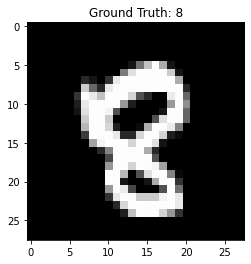

In [58]:
# lets grab something from the test set
import random
total_images = test_data_length # 10000
index = random.randint(0, total_images)
print("Random Test Image:", index)
count = 0
batch = index // test_kwargs["batch_size"]
batch_index = index % int(total_images / len(test_loader))
for tensor_ptr in test_loader:
    data, target = tensor_ptr[0], tensor_ptr[1]
    if batch == count:
        break
    count += 1

print(f"Displaying {index} == {batch_index} in Batch: {batch}/{len(test_loader)}")
image_1 = data[batch_index].reshape((28, 28))
label_1 = target[batch_index]
draw_image_and_label(image_1, label_1)

In [59]:
# # classify remote
# sy.logger.trace("Before running classify")
# class_num, preds = classify(image_1)
# print(f"Prediction: {class_num} Ground Truth: {label_1}")
# print(preds)

In [60]:
# classify local
sy.logger.trace("Before running classify")
class_num, preds = classify_local(image_1)
print(f"Prediction: {class_num} Ground Truth: {label_1}")
print(preds)

1 <class 'torch.Tensor'>
2 <class 'torch.Tensor'>
3 <class 'torch.Tensor'>
Prediction: 8 Ground Truth: 8
tensor([6.5405e-06, 1.8607e-06, 3.5482e-05, 8.5178e-08, 6.4590e-06, 1.1944e-05,
        2.5357e-06, 7.6778e-07, 9.9993e-01, 3.0234e-06],
       grad_fn=<SqueezeBackward0>)


2020-10-31 19:20:33.510 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:20:38.515 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:20:43.521 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:20:48.526 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:20:53.530 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:20:58.534 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:21:03.539 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:21:08.542 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:21:13.546 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:21:18.551 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:21:23.557 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:21:28.562 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:21:33.567 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


2020-10-31 19:21:38.572 | CRITICAL | syft.grid.connections.webrtc:heartbeat:562 - Joiner PQ: 0 / 0 - CQ: 0 / 0


Joiner PQ: 0 / 0 - CQ: 0 / 0


In [ ]:
# error with recv_immediate_msg_with_reply. 'generator' object has no attribute 'serialize'
# remote_model_params_ptr = model.parameters()
# remote_model_params = remote_model_params_ptr.get(
#     request_block=True,
#     request_name="copy_model",
#     reason="To run test and inference locally",
#     timeout_secs=10,
#     delete_obj=False,
# )

In [ ]:
# print(remote_model_params)